In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


dataset file is named meat_sales_data.csv and that it has no header row, we first define the column names. (The dataset’s first column is the sales date; the next columns indicate store status and day of the week; then seven price columns; and finally, seven quantity columns.)

In [5]:
file_path = r'D:\python_projects\OMDFM\mieso_dane_brzeznica_2.csv'

# Read the CSV; parse 'date' as a datetime column.
data = pd.read_csv(file_path, header=0, parse_dates=['date'])
data.head()


,date,store_open,closed_tomorrow,closed_next2,day_of_week,price_quarter,price_fillet,price_shoulder,price_drumstick,price_loin,price_wing,price_ham,sold_quarter,sold_fillet,sold_shoulder,sold_drumstick,sold_loin,sold_wing,sold_ham
0,2024-09-01,0,0,0,Sunday,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
1,2024-09-02,1,0,0,Monday,8.99,23.99,14.79,9.99,21.99,10.99,15.79,8.4,15.83,13.51,3.59,15.09,3.24,26.48
2,2024-09-03,1,0,0,Tuesday,8.99,23.99,14.84,9.99,21.99,10.99,16.24,13.9,13.37,13.26,10.63,11.66,5.69,20.41
3,2024-09-04,1,0,0,Wednesday,8.99,23.99,15.22,9.99,21.99,10.99,15.41,10.8,22.33,17.85,13.77,12.14,2.09,26.92
4,2024-09-05,1,0,0,Thursday,8.99,12.74,14.21,9.99,22.15,8.99,16.99,21.1,79.39,17.83,9.67,5.36,1.57,32.77


3. Data Preprocessing and Feature Engineering
- We convert categorical fields (like day of the week) into dummy variables, and we derive additional features. In this example, we create:

- An indicator for whether the store will be open the next day.
For each meat type, a feature for the average price of the other meats (to capture possible cross-effects).

In [6]:
numeric_cols = [
    'store_open', 'closed_tomorrow', 'closed_next2',
    'price_quarter', 'price_fillet', 'price_shoulder', 'price_drumstick',
    'price_loin', 'price_wing', 'price_ham',
    'sold_quarter', 'sold_fillet', 'sold_shoulder', 'sold_drumstick',
    'sold_loin', 'sold_wing', 'sold_ham'
]

for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')


In [7]:
print(data[numeric_cols].isna().sum())


store_open         0
closed_tomorrow    0
closed_next2       0
price_quarter      0
price_fillet       0
price_shoulder     0
price_drumstick    0
price_loin         0
price_wing         0
price_ham          0
sold_quarter       0
sold_fillet        0
sold_shoulder      0
sold_drumstick     0
sold_loin          0
sold_wing          0
sold_ham           0
dtype: int64


### Create Additional Features
> open_next_day: if closed_tomorrow == 1 (store closed), then 0; otherwise 1.
> Dummy variables for day_of_week.
> Average price of the other meats for each meat type.

In [8]:
# 1) open_next_day feature
data['open_next_day'] = data['closed_tomorrow'].apply(lambda x: 0 if x == 1 else 1)

# 2) Convert the day_of_week column to dummy variables
data = pd.get_dummies(data, columns=['day_of_week'], drop_first=True)

# 3) Create an average of other meats' prices for each meat type
meat_types = ["quarter", "fillet", "shoulder", "drumstick", "loin", "wing", "ham"]
for meat in meat_types:
    other_meats = [m for m in meat_types if m != meat]
    other_price_cols = [f"price_{m}" for m in other_meats]
    data[f"avg_other_price_{meat}"] = data[other_price_cols].mean(axis=1)


### Model Building: Train a Model for a Specific Meat Type
We’ll create a function that trains a Random Forest regressor for a single meat type. It:

Defines the feature columns.
1-  Splits into train/test.
2- Fits the model.
3- Prints out the Mean Absolute Percentage Error (MAPE).

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE).
    Ignores any entries where y_true == 0.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    nonzero_mask = (y_true != 0)
    if not np.any(nonzero_mask):
        return np.nan
    
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

def train_model_for_meat(meat, data):
    price_col = f"price_{meat}"
    sold_col = f"sold_{meat}"
    avg_other_col = f"avg_other_price_{meat}"

    feature_cols = [
        'store_open',
        'open_next_day',
        'closed_next2',
        price_col,
        avg_other_col
    ]
    
    # day_of_week dummies
    dummy_cols = [col for col in data.columns if col.startswith('day_of_week_')]
    feature_cols.extend(dummy_cols)
    
    X = data[feature_cols].copy()
    y = data[sold_col].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"MAPE for meat type '{meat}': {mape:.2f}%")
    
    return model, feature_cols, X_test, y_test, y_pred

# Usage:
model_quarter, features_quarter, X_test_q, y_test_q, y_pred_q = train_model_for_meat('quarter', data)


MAPE for meat type 'quarter': 42.68%


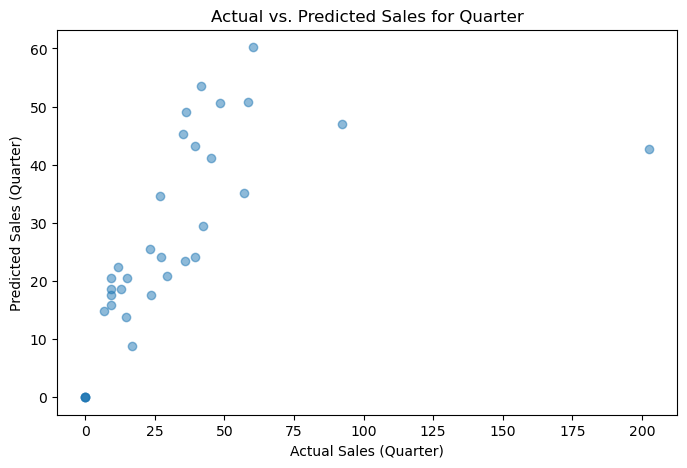

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test_q, y_pred_q, alpha=0.5)
plt.xlabel('Actual Sales (Quarter)')
plt.ylabel('Predicted Sales (Quarter)')
plt.title('Actual vs. Predicted Sales for Quarter')
plt.show()


### Create a Prediction Function

In [15]:
def predict_meat_sales(model, features, meat, 
                       store_open, open_next_day, closed_next2, 
                       day_of_week, planned_price, avg_other_price):
    """
    Predict the quantity sold for a given meat type on a specific day.
    """
    # Build a dictionary for the single-row input
    input_data = {
        'store_open': store_open,
        'open_next_day': open_next_day,
        'closed_next2': closed_next2,
        f'price_{meat}': planned_price,
        f'avg_other_price_{meat}': avg_other_price
    }
    
    # For the day_of_week dummy columns, set 1 for the matching day, else 0
    for col in features:
        if col.startswith('day_of_week_'):
            # col might be "day_of_week_Monday"
            if col == f"day_of_week_{day_of_week}":
                input_data[col] = 1
            else:
                input_data[col] = 0
    
    # Create a DataFrame for the input
    input_df = pd.DataFrame([input_data])
    
    # Predict
    prediction = model.predict(input_df)
    return prediction[0]

# Example usage: Predict for 'quarter'
historical_avg_other = data['avg_other_price_quarter'].mean()  # or a forecasted value
predicted_qty_quarter = predict_meat_sales(
    model_quarter, 
    features_quarter, 
    meat='quarter',
    store_open=1,
    open_next_day=1,
    closed_next2=0,
    day_of_week='Tuesday',
    planned_price=12.99,
    avg_other_price=historical_avg_other
)
print(f"Predicted quantity for 'quarter': {predicted_qty_quarter:.2f}")


Predicted quantity for 'quarter': 17.02


 ### Improve model performance 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor


In [18]:
file_path = r'D:\python_projects\OMDFM\mieso_dane_brzeznica_2.csv'
data = pd.read_csv(file_path, header=0, parse_dates=['date'])
data.head()


,date,store_open,closed_tomorrow,closed_next2,day_of_week,price_quarter,price_fillet,price_shoulder,price_drumstick,price_loin,price_wing,price_ham,sold_quarter,sold_fillet,sold_shoulder,sold_drumstick,sold_loin,sold_wing,sold_ham
0,2024-09-01,0,0,0,Sunday,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
1,2024-09-02,1,0,0,Monday,8.99,23.99,14.79,9.99,21.99,10.99,15.79,8.4,15.83,13.51,3.59,15.09,3.24,26.48
2,2024-09-03,1,0,0,Tuesday,8.99,23.99,14.84,9.99,21.99,10.99,16.24,13.9,13.37,13.26,10.63,11.66,5.69,20.41
3,2024-09-04,1,0,0,Wednesday,8.99,23.99,15.22,9.99,21.99,10.99,15.41,10.8,22.33,17.85,13.77,12.14,2.09,26.92
4,2024-09-05,1,0,0,Thursday,8.99,12.74,14.21,9.99,22.15,8.99,16.99,21.1,79.39,17.83,9.67,5.36,1.57,32.77


In [19]:
numeric_cols = [
    'store_open', 'closed_tomorrow', 'closed_next2',
    'price_quarter', 'price_fillet', 'price_shoulder', 'price_drumstick',
    'price_loin', 'price_wing', 'price_ham',
    'sold_quarter', 'sold_fillet', 'sold_shoulder', 'sold_drumstick',
    'sold_loin', 'sold_wing', 'sold_ham'
]

for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')


In [20]:
# Create open_next_day: if closed_tomorrow is 1 then store is closed, else open (1)
data['open_next_day'] = data['closed_tomorrow'].apply(lambda x: 0 if x == 1 else 1)

# Create dummy variables for day_of_week (drop first to avoid collinearity)
data = pd.get_dummies(data, columns=['day_of_week'], drop_first=True)


In [21]:
meat_types = ["quarter", "fillet", "shoulder", "drumstick", "loin", "wing", "ham"]
for meat in meat_types:
    other_meats = [m for m in meat_types if m != meat]
    other_price_cols = [f"price_{m}" for m in other_meats]
    data[f"avg_other_price_{meat}"] = data[other_price_cols].mean(axis=1)


In [22]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE),
    ignoring cases where y_true == 0.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Mask out zeros in y_true
    nonzero_mask = (y_true != 0)
    if not np.any(nonzero_mask):
        return np.nan
    
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100


In [23]:
def train_model_for_meat_improved(meat, data):
    """
    Train a RandomForestRegressor for the given meat type (e.g., 'quarter')
    using a lag feature and hyperparameter tuning.
    
    Returns:
      - best_model: The tuned RandomForestRegressor
      - feature_cols: List of features used in the model
      - X_test, y_test, y_pred: Data for evaluation/plotting
    """
    # Sort data by date (required for lag features)
    data = data.sort_values(by='date').copy()
    
    # Create lag feature for the target meat (lag of 1 day)
    lag_feature = f"lag1_sold_{meat}"
    data[lag_feature] = data[f"sold_{meat}"].shift(1)
    
    # Drop rows where lag is not available
    data = data.dropna(subset=[lag_feature])
    
    # Define column names for the meat type
    price_col = f"price_{meat}"
    sold_col = f"sold_{meat}"
    avg_other_col = f"avg_other_price_{meat}"
    
    # Base features, including the lag feature
    feature_cols = [
        'store_open',
        'open_next_day',
        'closed_next2',
        price_col,
        avg_other_col,
        lag_feature
    ]
    
    # Include day_of_week dummy variables
    dummy_cols = [col for col in data.columns if col.startswith('day_of_week_')]
    feature_cols.extend(dummy_cols)
    
    X = data[feature_cols].copy()
    y = data[sold_col].copy()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Define a parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, scoring='neg_mean_absolute_percentage_error',
                               cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Compute MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"Improved MAPE for meat type '{meat}': {mape:.2f}%")
    print("Best hyperparameters:", grid_search.best_params_)
    
    return best_model, feature_cols, X_test, y_test, y_pred

# Train the improved model for 'quarter'
model_quarter_improved, features_quarter_improved, X_test_q_imp, y_test_q_imp, y_pred_q_imp = train_model_for_meat_improved('quarter', data)


Improved MAPE for meat type 'quarter': 79.06%
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


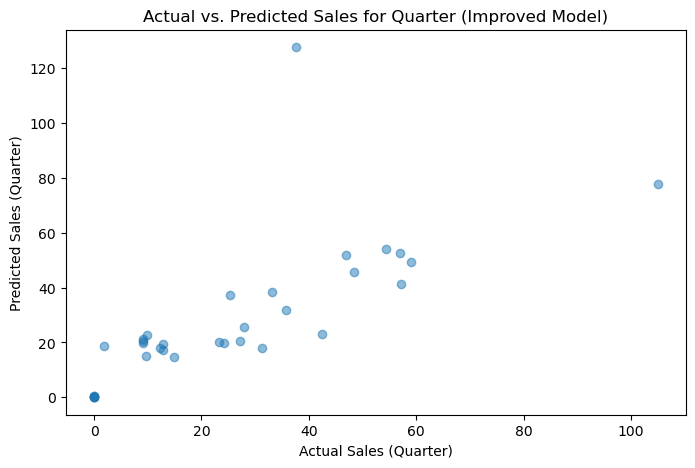

In [24]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test_q_imp, y_pred_q_imp, alpha=0.5)
plt.xlabel('Actual Sales (Quarter)')
plt.ylabel('Predicted Sales (Quarter)')
plt.title('Actual vs. Predicted Sales for Quarter (Improved Model)')
plt.show()


In [25]:
### forcasting function

In [26]:
import pandas as pd
import numpy as np

def forecast_future_usage(model, features, meat, start_date, end_date, planned_price, avg_other_price):
    """
    Forecast future sales for a given meat type using a recursive strategy
    (using the previous day's prediction as a lag feature).
    
    Parameters:
      - model: the trained model (e.g., model_quarter_improved)
      - features: list of feature columns used in the model
      - meat: meat type as a string (e.g., 'quarter')
      - start_date, end_date: forecast period as datetime objects or strings
      - planned_price: the planned price to use in the forecast for this meat
      - avg_other_price: the average price of the other meats (can be historical average)
    
    Returns:
      - forecast_df: a DataFrame containing forecast dates and predicted sales
    """
    # Create date range for forecast
    forecast_dates = pd.date_range(start=start_date, end=end_date)
    forecast_df = pd.DataFrame({'date': forecast_dates})
    
    # Determine the day name for each forecast date
    forecast_df['day_of_week'] = forecast_df['date'].dt.day_name()
    
    # Set default features
    forecast_df['store_open'] = 1
    forecast_df['open_next_day'] = 1
    forecast_df['closed_next2'] = 0
    forecast_df[f'price_{meat}'] = planned_price
    forecast_df[f'avg_other_price_{meat}'] = avg_other_price

    # The lag feature: name matches the one used during training, e.g., "lag1_sold_quarter"
    lag_col = f'lag1_sold_{meat}'
    forecast_df[lag_col] = np.nan

    # Get dummy columns from the model's features (e.g., "day_of_week_Monday", etc.)
    dummy_cols = [col for col in features if col.startswith('day_of_week_')]
    for col in dummy_cols:
        # The dummy column name is like "day_of_week_Tuesday" – extract the day name
        day_name = col.split('_')[2]
        forecast_df[col] = (forecast_df['day_of_week'] == day_name).astype(int)
    
    # Initialize the lag feature with the last known sales value from historical data.
    initial_lag = data[f'sold_{meat}'].iloc[-1]
    
    # List to hold predictions
    predictions = []
    
    # Recursively forecast each day
    for i in range(len(forecast_df)):
        if i == 0:
            current_lag = initial_lag
        else:
            current_lag = predictions[-1]
        
        forecast_df.at[i, lag_col] = current_lag
        
        # Build input features for this forecast day
        input_data = {
            'store_open': 1,
            'open_next_day': 1,
            'closed_next2': 0,
            f'price_{meat}': planned_price,
            f'avg_other_price_{meat}': avg_other_price,
            lag_col: current_lag
        }
        for col in dummy_cols:
            input_data[col] = forecast_df.at[i, col]
        
        input_df = pd.DataFrame([input_data])
        pred = model.predict(input_df)[0]
        predictions.append(pred)
    
    forecast_df[f'sold_{meat}_forecast'] = predictions
    return forecast_df


In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define forecast parameters
start_date = '2025-03-01'
end_date = '2025-03-31'  # Forecast for the next month (adjust as needed)
planned_price = 12.99  # Example planned price for 'quarter'
avg_other_price = data['avg_other_price_quarter'].mean()  # Historical average of other prices

# Generate the forecast DataFrame using the improved model for 'quarter'
forecast_df = forecast_future_usage(model_quarter_improved, features_quarter_improved,
                                    meat='quarter', start_date=start_date, end_date=end_date,
                                    planned_price=planned_price, avg_other_price=avg_other_price)

# Preview forecast results
forecast_df.head()


,date,day_of_week,store_open,open_next_day,closed_next2,price_quarter,avg_other_price_quarter,lag1_sold_quarter,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,sold_quarter_forecast
0,2025-03-01,Saturday,1,1,0,12.99,13.30396,68.700,0,0,0,0,0,0,14.880
1,2025-03-02,Sunday,1,1,0,12.99,13.30396,14.880,0,0,0,0,0,0,14.346
2,2025-03-03,Monday,1,1,0,12.99,13.30396,14.346,0,0,0,0,0,0,14.172
3,2025-03-04,Tuesday,1,1,0,12.99,13.30396,14.172,0,0,0,0,0,0,14.172
4,2025-03-05,Wednesday,1,1,0,12.99,13.30396,14.172,0,0,0,0,0,0,14.172


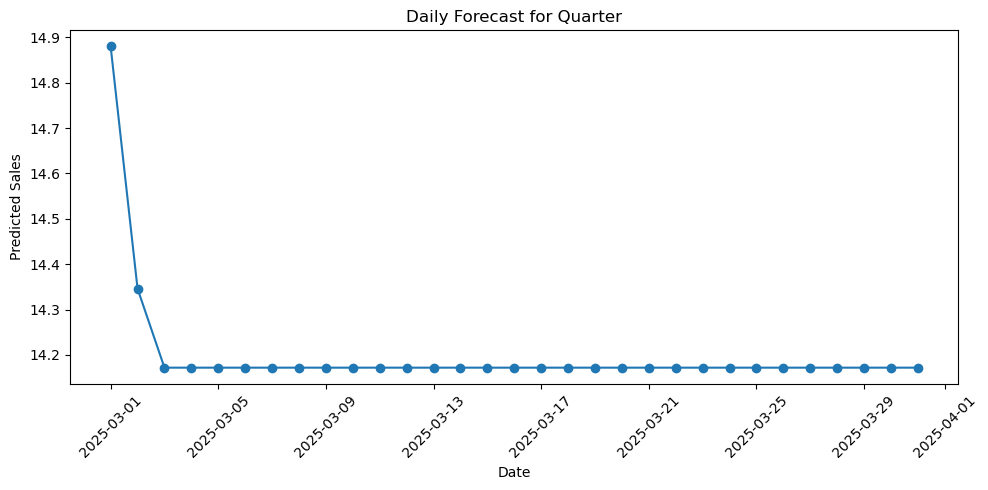

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(forecast_df['date'], forecast_df['sold_quarter_forecast'], marker='o', linestyle='-')
plt.title('Daily Forecast for Quarter')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


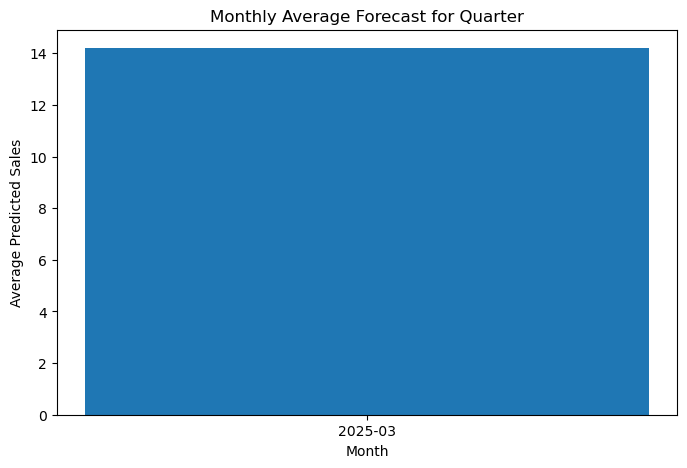

In [29]:
# Add a month column
forecast_df['month'] = forecast_df['date'].dt.to_period('M')
monthly_forecast = forecast_df.groupby('month')['sold_quarter_forecast'].mean().reset_index()
monthly_forecast['month'] = monthly_forecast['month'].astype(str)

plt.figure(figsize=(8, 5))
plt.bar(monthly_forecast['month'], monthly_forecast['sold_quarter_forecast'])
plt.title('Monthly Average Forecast for Quarter')
plt.xlabel('Month')
plt.ylabel('Average Predicted Sales')
plt.show()


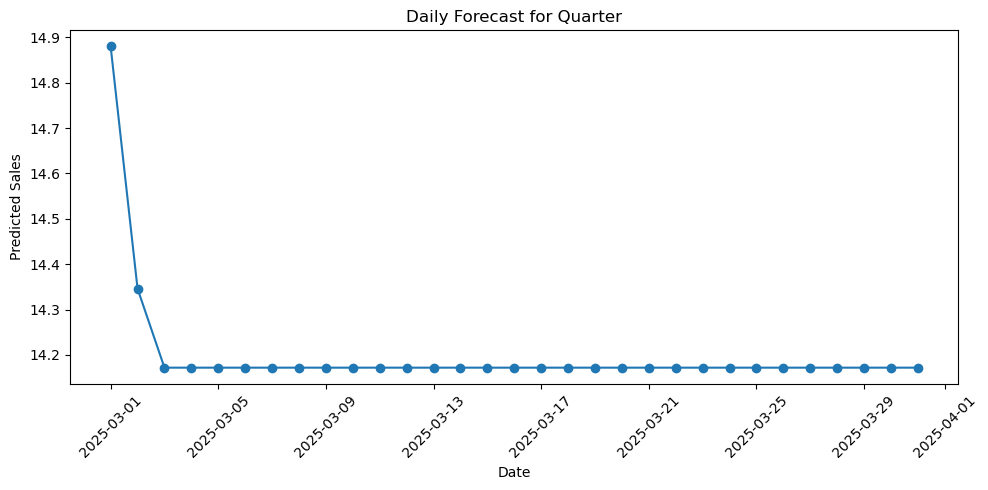

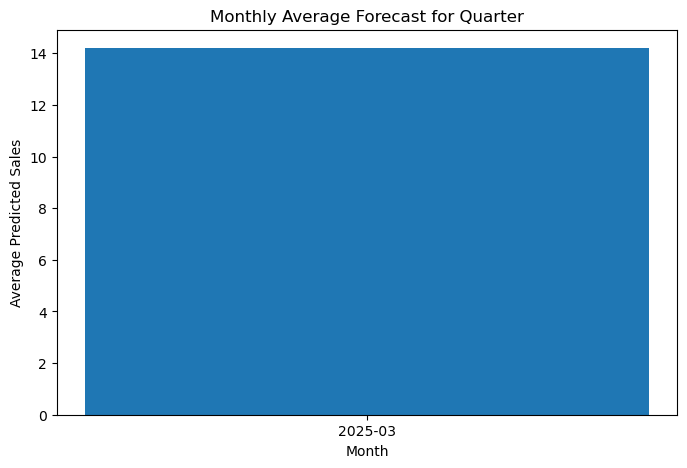

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def forecast_future_usage(model, features, meat, start_date, end_date, planned_price, avg_other_price):
    """
    Forecast future sales for a given meat type using a recursive strategy.
    """
    # Create date range for forecast
    forecast_dates = pd.date_range(start=start_date, end=end_date)
    forecast_df = pd.DataFrame({'date': forecast_dates})
    
    # Determine day names for the forecast dates
    forecast_df['day_of_week'] = forecast_df['date'].dt.day_name()
    
    # Set constant features
    forecast_df['store_open'] = 1
    forecast_df['open_next_day'] = 1
    forecast_df['closed_next2'] = 0
    forecast_df[f'price_{meat}'] = planned_price
    forecast_df[f'avg_other_price_{meat}'] = avg_other_price

    # Define the lag feature column (e.g., "lag1_sold_quarter")
    lag_col = f'lag1_sold_{meat}'
    forecast_df[lag_col] = np.nan

    # Create dummy variables for day_of_week
    dummy_cols = [col for col in features if col.startswith('day_of_week_')]
    for col in dummy_cols:
        day_name = col.split('_')[2]
        forecast_df[col] = (forecast_df['day_of_week'] == day_name).astype(int)
    
    # Initialize the lag feature with the last known sale from historical data
    initial_lag = data[f'sold_{meat}'].iloc[-1]
    
    predictions = []
    for i in range(len(forecast_df)):
        current_lag = initial_lag if i == 0 else predictions[-1]
        forecast_df.at[i, lag_col] = current_lag
        
        # Prepare input features for the current day
        input_data = {
            'store_open': 1,
            'open_next_day': 1,
            'closed_next2': 0,
            f'price_{meat}': planned_price,
            f'avg_other_price_{meat}': avg_other_price,
            lag_col: current_lag
        }
        for col in dummy_cols:
            input_data[col] = forecast_df.at[i, col]
        
        input_df = pd.DataFrame([input_data])
        pred = model.predict(input_df)[0]
        predictions.append(pred)
    
    forecast_df[f'sold_{meat}_forecast'] = predictions
    return forecast_df

# Forecast parameters (adjust as needed)
start_date = '2025-03-01'
end_date = '2025-03-31'
planned_price = 12.99
avg_other_price = data['avg_other_price_quarter'].mean()

# Generate forecast DataFrame using the improved model for 'quarter'
forecast_df = forecast_future_usage(model_quarter_improved, features_quarter_improved,
                                    meat='quarter', start_date=start_date, end_date=end_date,
                                    planned_price=planned_price, avg_other_price=avg_other_price)

# --- Visualization ---

# Daily Forecast Line Plot
plt.figure(figsize=(10, 5))
plt.plot(forecast_df['date'], forecast_df['sold_quarter_forecast'], marker='o', linestyle='-')
plt.title('Daily Forecast for Quarter')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly Forecast (Aggregated) Bar Chart
forecast_df['month'] = forecast_df['date'].dt.to_period('M')
monthly_forecast = forecast_df.groupby('month')['sold_quarter_forecast'].mean().reset_index()
monthly_forecast['month'] = monthly_forecast['month'].astype(str)

plt.figure(figsize=(8, 5))
plt.bar(monthly_forecast['month'], monthly_forecast['sold_quarter_forecast'])
plt.title('Monthly Average Forecast for Quarter')
plt.xlabel('Month')
plt.ylabel('Average Predicted Sales')
plt.show()


Original data shape: (165, 19)
Data shape after excluding Christmas season: (154, 19)
Improved MAPE for meat type 'quarter': 104.06%
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


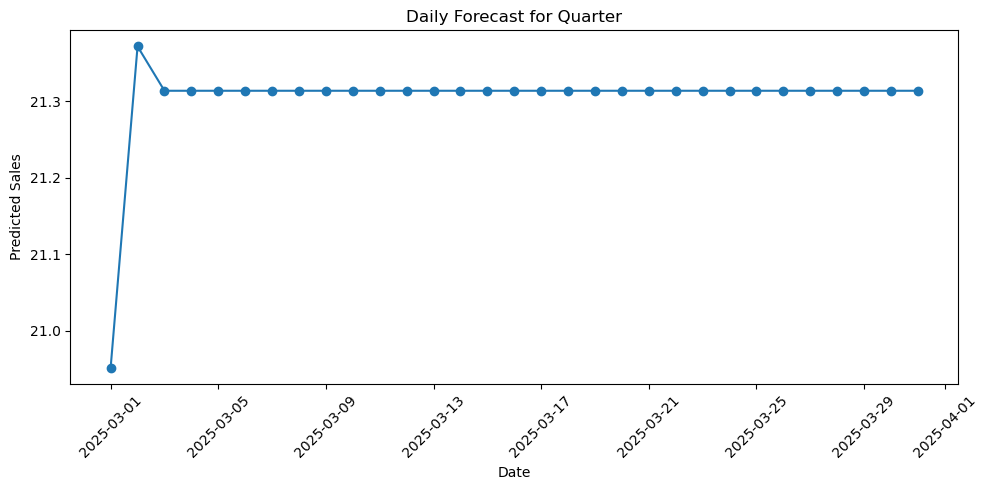

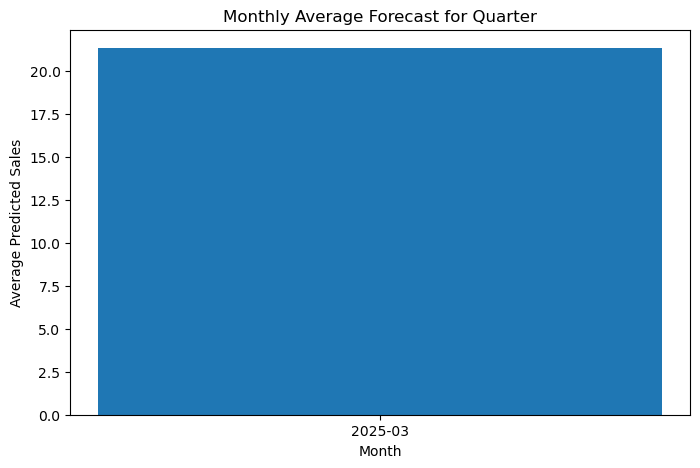

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 1. Load the Data
file_path = r'D:\python_projects\OMDFM\mieso_dane_brzeznica_2.csv'
data = pd.read_csv(file_path, header=0, parse_dates=['date'])
print("Original data shape:", data.shape)

# Exclude data from December 15, 2024 to December 25, 2024
mask = ~((data['date'] >= '2024-12-15') & (data['date'] <= '2024-12-25'))
data = data.loc[mask]
print("Data shape after excluding Christmas season:", data.shape)

# 2. Data Preprocessing & Conversion
numeric_cols = [
    'store_open', 'closed_tomorrow', 'closed_next2',
    'price_quarter', 'price_fillet', 'price_shoulder', 'price_drumstick',
    'price_loin', 'price_wing', 'price_ham',
    'sold_quarter', 'sold_fillet', 'sold_shoulder', 'sold_drumstick',
    'sold_loin', 'sold_wing', 'sold_ham'
]

for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# 3. Feature Engineering

# Create additional feature: open_next_day (1 if open, 0 if closed tomorrow)
data['open_next_day'] = data['closed_tomorrow'].apply(lambda x: 0 if x == 1 else 1)

# Create dummy variables for day_of_week (dropping the first category)
data = pd.get_dummies(data, columns=['day_of_week'], drop_first=True)

# Create average price features for each meat type
meat_types = ["quarter", "fillet", "shoulder", "drumstick", "loin", "wing", "ham"]
for meat in meat_types:
    other_meats = [m for m in meat_types if m != meat]
    other_price_cols = [f"price_{m}" for m in other_meats]
    data[f"avg_other_price_{meat}"] = data[other_price_cols].mean(axis=1)

# 4. Define MAPE Function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    nonzero_mask = (y_true != 0)
    if not np.any(nonzero_mask):
        return np.nan
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

# 5. Improved Model Training with Lag Feature & Hyperparameter Tuning for 'quarter'
def train_model_for_meat_improved(meat, data):
    # Sort data by date (important for lag features)
    data = data.sort_values(by='date').copy()
    
    # Create a lag feature for previous day's sales (e.g., "lag1_sold_quarter")
    lag_feature = f"lag1_sold_{meat}"
    data[lag_feature] = data[f"sold_{meat}"].shift(1)
    
    # Drop rows with missing lag values
    data = data.dropna(subset=[lag_feature])
    
    # Define feature and target columns
    price_col = f"price_{meat}"
    sold_col = f"sold_{meat}"
    avg_other_col = f"avg_other_price_{meat}"
    
    feature_cols = [
        'store_open', 'open_next_day', 'closed_next2',
        price_col, avg_other_col, lag_feature
    ]
    dummy_cols = [col for col in data.columns if col.startswith('day_of_week_')]
    feature_cols.extend(dummy_cols)
    
    X = data[feature_cols].copy()
    y = data[sold_col].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, scoring='neg_mean_absolute_percentage_error',
                               cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"Improved MAPE for meat type '{meat}': {mape:.2f}%")
    print("Best hyperparameters:", grid_search.best_params_)
    
    return best_model, feature_cols, X_test, y_test, y_pred

# Train the model for 'quarter'
model_quarter_improved, features_quarter_improved, X_test_q_imp, y_test_q_imp, y_pred_q_imp = train_model_for_meat_improved('quarter', data)

# 6. Forecasting Future Usage (Recursive Forecast)
def forecast_future_usage(model, features, meat, start_date, end_date, planned_price, avg_other_price):
    # Create forecast date range
    forecast_dates = pd.date_range(start=start_date, end=end_date)
    forecast_df = pd.DataFrame({'date': forecast_dates})
    forecast_df['day_of_week'] = forecast_df['date'].dt.day_name()
    
    # Set constant features for forecast period
    forecast_df['store_open'] = 1
    forecast_df['open_next_day'] = 1
    forecast_df['closed_next2'] = 0
    forecast_df[f'price_{meat}'] = planned_price
    forecast_df[f'avg_other_price_{meat}'] = avg_other_price
    
    # Initialize lag feature column (e.g., "lag1_sold_quarter")
    lag_col = f'lag1_sold_{meat}'
    forecast_df[lag_col] = np.nan
    
    # Create dummy variables for day_of_week based on training features
    dummy_cols = [col for col in features if col.startswith('day_of_week_')]
    for col in dummy_cols:
        day_name = col.split('_')[2]
        forecast_df[col] = (forecast_df['day_of_week'] == day_name).astype(int)
    
    # Initialize the first lag value using the last known sale from historical data
    initial_lag = data[f'sold_{meat}'].iloc[-1]
    
    predictions = []
    for i in range(len(forecast_df)):
        current_lag = initial_lag if i == 0 else predictions[-1]
        forecast_df.at[i, lag_col] = current_lag
        
        input_data = {
            'store_open': 1,
            'open_next_day': 1,
            'closed_next2': 0,
            f'price_{meat}': planned_price,
            f'avg_other_price_{meat}': avg_other_price,
            lag_col: current_lag
        }
        for col in dummy_cols:
            input_data[col] = forecast_df.at[i, col]
        
        input_df = pd.DataFrame([input_data])
        pred = model.predict(input_df)[0]
        predictions.append(pred)
    
    forecast_df[f'sold_{meat}_forecast'] = predictions
    return forecast_df

# Define forecast parameters
start_date = '2025-03-01'
end_date = '2025-03-31'
planned_price = 12.99
avg_other_price = data['avg_other_price_quarter'].mean()

# Generate forecast DataFrame for 'quarter'
forecast_df = forecast_future_usage(model_quarter_improved, features_quarter_improved,
                                    meat='quarter', start_date=start_date, end_date=end_date,
                                    planned_price=planned_price, avg_other_price=avg_other_price)

# 7. Visualization of Forecasts

# Daily Forecast Visualization (Line Plot)
plt.figure(figsize=(10, 5))
plt.plot(forecast_df['date'], forecast_df['sold_quarter_forecast'], marker='o', linestyle='-')
plt.title('Daily Forecast for Quarter')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly Aggregated Forecast (Bar Chart)
forecast_df['month'] = forecast_df['date'].dt.to_period('M')
monthly_forecast = forecast_df.groupby('month')['sold_quarter_forecast'].mean().reset_index()
monthly_forecast['month'] = monthly_forecast['month'].astype(str)

plt.figure(figsize=(8, 5))
plt.bar(monthly_forecast['month'], monthly_forecast['sold_quarter_forecast'])
plt.title('Monthly Average Forecast for Quarter')
plt.xlabel('Month')
plt.ylabel('Average Predicted Sales')
plt.show()
